In [1]:
# import packages
import os
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np  
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False 

In [7]:
directory = os.getcwd()
ot_filename = "6Para_0827-0828.csv"
ot_file_path = os.path.join(directory, 'input', ot_filename)
recommendation_filename = "yng_recommend_weight_data_log.csv"
recommendation_file_path = os.path.join(directory, 'input', recommendation_filename)

recommendation_data = pd.read_csv(recommendation_file_path)
recommendation_data.columns

Index(['id', 'is_change', 'sku', 'formula', 'extruder_temperature',
       'slice_product_line_speed', 'target_weight', 'data_time', 'weight_ts',
       'shift', 'actual_weight', 'ai_res_actual_weight',
       'recommend_1_roller_gap', 'recommend_2_roller_gap',
       'recommend_3_roller_gap', 'recommend_forming_roller_gap',
       'recommend_extruder_temperature', 'recommend_cross_cutter_speed',
       'predicted_weight_before_change', 'predicted_weight_after_change',
       'recommend_weight_data_id', 'create_by', 'update_by', 'create_time',
       'update_time'],
      dtype='object')

In [15]:
ot_data = pd.read_csv(ot_file_path)
# 定义正确的标题
expected_header = ['Tag', 'Value', 'TS'] 
expected_header = ['Tag', 'TS', 'Value'] # 后面改回上一行

current_header = ot_data.columns.tolist()
if current_header != expected_header:
    ot_data = pd.read_csv(ot_file_path, header=None, names=expected_header)
else:
    ot_data = pd.read_csv(ot_file_path)

# Define the function to format the datetime columns in a DataFrame
def format_datetime_columns(df, column_names):
    for column in column_names:
        # Convert to datetime, handle mixed formats, and remove timezone information
        df[column] = pd.to_datetime(df[column], utc=True).dt.tz_localize(None)
        df[column] = df[column].dt.floor('s')
    return df

# format TS
ot_data = format_datetime_columns(ot_data, ['TS'])

In [16]:
parameter_dict = {
    "recommend_1_roller_gap": "CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches",
    "recommend_2_roller_gap": "CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches",
    "recommend_3_roller_gap": "CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSizing.rActualPosition_inches",
    "recommend_forming_roller_gap": "CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_GapFinalSizing.rActualPosition_inches",
    "recommend_extruder_temperature": "SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_PH_Temp_SP",
    "recommend_cross_cutter_speed": "CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rSetpoint_Ratio"
}

# 去掉不要的参数列
key_tag_list = list(parameter_dict.values())

# Filter the DataFrame to include only the rows where 'Tag' is in key_tag_list
df_ot = ot_data[ot_data['Tag'].isin(key_tag_list)].reset_index(drop=True)

In [17]:
set(df_ot['Tag'])

{'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches',
 'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches',
 'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSizing.rActualPosition_inches',
 'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_GapFinalSizing.rActualPosition_inches',
 'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_PH_Temp_SP'}

In [18]:
df_ot = df_ot.sort_values(by=['Tag','TS']) # sort by Tag, then TS
df_ot['Value'] = df_ot['Value'].round(4)

# We compare only the 'Value' column of each row with the previous one
# and also check for the first occurrence of each 'Tag'
diff_percent = 0.01
mask = ((df_ot['Value']-df_ot['Value'].shift()).abs() > diff_percent * df_ot['Value'].shift().abs()) | (df_ot['Tag'].ne(df_ot['Tag'].shift()))

# Apply the mask to filter the DataFrame
df_ot = df_ot[mask].reset_index(drop=True)
df_ot['Last_Value'] = np.where(df_ot['Tag'] == df_ot['Tag'].shift(), df_ot['Value'].shift(), np.nan)

df_ot

,Tag,TS,Value,Last_Value
0,CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap...,2024-08-27 21:00:00,0.1105,NaN
1,CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap...,2024-08-27 21:25:45,0.1201,0.1105
2,CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap...,2024-08-27 21:25:46,0.1343,0.1201
3,CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap...,2024-08-27 21:25:47,0.1587,0.1343
4,CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap...,2024-08-27 21:25:48,0.1801,0.1587
...,...,...,...,...
340,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT...,2024-08-28 01:34:59,60.0000,65.0000
341,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT...,2024-08-28 03:26:02,65.0000,60.0000
342,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT...,2024-08-28 03:28:35,60.0000,65.0000
343,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT...,2024-08-28 04:10:06,65.0000,60.0000


In [19]:
start_dt = df_ot['TS'].min().strftime('%Y%m%d')
end_dt = df_ot['TS'].max().strftime('%Y%m%d')
df_ot.to_excel(f'output/sorted_ot_data_{start_dt}_{end_dt}.xlsx')

In [20]:
# format TS
recommendation_data = format_datetime_columns(recommendation_data, ['data_time', 'weight_ts'])
# recommendation_data['data_time'][0]

# Define the function to check for OT changes within a 2-minute window
def check_ot_changes(df, ot_data, para_names, ts_column, window_size=180):
    # Iterate over each parameter name
    for para_name in para_names:
        para_tag = parameter_dict.get(para_name) # based on dictionary
        print(f'Checking for {para_name}')
        
        # Initialize a list to store the changes for this parameter
        changes = []
        
        # Iterate over each row in the recommendation_data DataFrame
        for index, row in df.iterrows():
            # Define the time window
            start_time = row[ts_column] - pd.Timedelta(seconds=window_size)
            end_time = row[ts_column] + pd.Timedelta(seconds=window_size)

            # Filter the ot_data for the time window and the current tag
            filtered_ot = ot_data[(ot_data['TS'] >= start_time) & (ot_data['TS'] <= end_time) & (ot_data['Tag'] == para_tag)]

            # Check if there's more than one unique value for the tag within the time window
            if len(filtered_ot['Value'].unique()) > 1:
                unique_values = filtered_ot['Value'].unique()
                change_string = '->'.join(map(str, unique_values))
                changes.append(change_string)  # Record all changes
            else:
                changes.append('')  # No change
        
        # Create a new column in the recommendation_data DataFrame to store the changes
        # Use the tag name followed by '_change' as the column name
        df[f'{para_name}_change'] = changes
    
    return df

# Apply the function to the recommendation_data DataFrame
para_names = [
    'recommend_1_roller_gap', 'recommend_2_roller_gap','recommend_3_roller_gap','recommend_forming_roller_gap'
    ,'recommend_cross_cutter_speed','recommend_extruder_temperature'
              ] 

recommendation_data = check_ot_changes(
    recommendation_data,
    df_ot,  # The DataFrame containing OT data
    para_names, ts_column='weight_ts'
)

Checking for recommend_1_roller_gap
Checking for recommend_2_roller_gap
Checking for recommend_3_roller_gap
Checking for recommend_forming_roller_gap
Checking for recommend_cross_cutter_speed
Checking for recommend_extruder_temperature


In [21]:
recommendation_data[recommendation_data['recommend_cross_cutter_speed'] != '']

,id,is_change,sku,formula,extruder_temperature,slice_product_line_speed,target_weight,data_time,weight_ts,shift,...,create_by,update_by,create_time,update_time,recommend_1_roller_gap_change,recommend_2_roller_gap_change,recommend_3_roller_gap_change,recommend_forming_roller_gap_change,recommend_cross_cutter_speed_change,recommend_extruder_temperature_change
0,1,0,EXSM,EXSM-Add LC-63 Non-G,64.70,139.58,2.71,2024-08-27 21:30:31,2024-08-27 21:05:55,中班,...,SYSTEM,SYSTEM,2024-08-27 21:30:32,2024-08-27 21:30:32,,,0.0722->0.0714,,,
1,2,0,EXSM,EXSM-Add LC-63 Non-G,64.70,139.58,2.71,2024-08-27 21:30:31,2024-08-27 21:05:55,中班,...,SYSTEM,SYSTEM,2024-08-27 21:30:32,2024-08-27 21:30:32,,,0.0722->0.0714,,,
2,3,0,EXSM,EXSM-Add LC-63 Non-G,64.41,168.51,2.71,2024-08-27 21:30:45,2024-08-27 21:05:55,中班,...,SYSTEM,SYSTEM,2024-08-27 21:30:46,2024-08-27 21:30:46,,,0.0722->0.0714,,,
3,4,0,EXSM,EXSM-Add LC-63 Non-G,64.41,168.51,2.71,2024-08-27 21:30:45,2024-08-27 21:05:55,中班,...,SYSTEM,SYSTEM,2024-08-27 21:30:46,2024-08-27 21:30:46,,,0.0722->0.0714,,,
4,5,0,EXSM,EXSM-Add LC-63 Non-G,65.09,168.60,2.71,2024-08-27 21:31:00,2024-08-27 21:05:55,中班,...,SYSTEM,SYSTEM,2024-08-27 21:31:01,2024-08-27 21:31:01,,,0.0722->0.0714,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4639,5152,1,RPWP,RPWP-1572171-550kg,64.81,0.00,2.71,2024-08-28 08:16:30,2024-08-28 07:57:25,晚班,...,SYSTEM,SYSTEM,2024-08-28 08:16:31,2024-08-28 08:16:31,,,0.0715->0.07,,,
4640,5153,1,RPWP,RPWP-1572171-550kg,64.47,0.00,2.71,2024-08-28 08:16:45,2024-08-28 07:57:25,晚班,...,SYSTEM,SYSTEM,2024-08-28 08:16:46,2024-08-28 08:16:46,,,0.0715->0.07,,,
4641,5154,1,RPWP,RPWP-1572171-550kg,64.47,0.00,2.71,2024-08-28 08:16:45,2024-08-28 07:57:25,晚班,...,SYSTEM,SYSTEM,2024-08-28 08:16:46,2024-08-28 08:16:46,,,0.0715->0.07,,,
4642,5155,1,RPWP,RPWP-1572171-550kg,65.21,0.00,2.71,2024-08-28 08:17:00,2024-08-28 07:57:25,晚班,...,SYSTEM,SYSTEM,2024-08-28 08:17:00,2024-08-28 08:17:00,,,0.0715->0.07,,,


In [22]:
start_dt = recommendation_data['data_time'].min().strftime('%Y%m%d')
end_dt = recommendation_data['data_time'].max().strftime('%Y%m%d')
print(recommendation_data['data_time'].min(), recommendation_data['data_time'].max())

2024-08-27 21:30:31 2024-08-28 08:17:00


#### Adoption% Review

In [31]:
def create_adoption_columns(df, para_names):
    for para_name in para_names:
        # 检查para_names中的列是否在DataFrame中
        if para_name not in df.columns:
            raise ValueError(f"Column {para_name} not found in DataFrame.")
        
        para_col = para_name
        change_col = f'{para_name}_change' # capture OT change
        adoption_col = f'{para_name}_adoption'

        df[adoption_col] = np.where(
            (df[para_col] != '') & (df[change_col] == ''), 
            100,  # AI推荐，操作员没调整
            np.where(
                (df[para_col] == '') & (df[change_col] != ''), 
                200,  # 操作员调整，AI没推荐
                np.where(
                    (df[para_col] != '') & (df[change_col] != '') & # (df[para_col] == df[change_col]), 
                    (df[para_col].astype(float) == df[change_col].str.split('->').str[-1].apply(lambda x: float(x) if x != '' else np.nan)), # 模型推荐值和OT最终值做对比
                    300,  # AI推荐，操作员调整，两者一致
                    400  # AI推荐，操作员调整，两者不一致
                )
            )
        )

        # 记录recommendation_no
        df['recommendation_no'] = 0
        recommendation_no = 1
        for i in range(1, len(df)):
            # 检查当前行的参数是否与上一行相同
            if not df.loc[i, para_names].equals(df.loc[i-1, para_names]):
                recommendation_no += 1
            df.loc[i, 'recommendation_no'] = recommendation_no

        # calculate the adoption % for each parameter
        adoption_rate = df[df[adoption_col].isin([300, 400])].shape[0] / df.shape[0] * 100
        print(f'{para_name} has adoption rate {adoption_rate:.2f}%.')

    # calculate the overall adoption %
    adoption_columns = [col for col in df.columns if col.endswith('_adoption')]
    df['is_adopted'] = df[adoption_columns].apply(lambda row: row.isin([300, 400]).any(), axis=1)
    
    overall_adoption_rate = df['is_adopted'].sum() / df.shape[0] * 100

    print("\n-----------  Summary  -----------")
    print(f'The recommendation has an overall adoption rate {overall_adoption_rate:.2f}%.')

    if 'operator_status' in df.columns:
        status_counts = df['operator_status'].value_counts()
        a = status_counts.get(1, 0)  # count of 接受
        b = status_counts.get(2, 0)  # count of 修改
        c = status_counts.get(3, 0)  # count of 解决
        d = status_counts.get(0, 0)  # count of 未操作
        print(f'The system has an overall adoption rate (1-d/(a+b+c+d)) {1-d/(a+b+c+d):.2f}%.')
        print(f'The system has an overall acceptance rate (1-c/(a+b+c)) {1-c/(a+b+c):.2f}%.')
        print(f'The system has an overall acceptance rate (c/(a+b+c)) {c/(a+b+c):.2f}%.')
    else:
        print("Error: 'operator_status' column does not exist in the dataframe.")
    


    return df


df_mapped = recommendation_data.copy()
df_mapped = create_adoption_columns(df_mapped, para_names)


recommend_1_roller_gap has adoption rate 0.00%.
recommend_2_roller_gap has adoption rate 2.58%.
recommend_3_roller_gap has adoption rate 6.65%.
recommend_forming_roller_gap has adoption rate 4.18%.
recommend_cross_cutter_speed has adoption rate 0.00%.
recommend_extruder_temperature has adoption rate 0.00%.

-----------  Summary  -----------
The recommendation has an overall adoption rate 8.25%.
Error: 'operator_status' column does not exist in the dataframe.


In [29]:
df_mapped
df_mapped.to_excel(f'output/ot_model_mapping_{start_dt}_{end_dt}.xlsx', index=False)

#### Value Tracking

In [26]:
def calculate_cpk(data, usl, lsl):
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    print(f'Overall, we have an averaged gum weight {mean/13:.2f}g per slice with variance {std_dev**2:.2f}.')
    
    # Calculate CPU and CPL
    cpu = (usl - mean) / (3 * std_dev)
    cpl = (mean - lsl) / (3 * std_dev)
    cpk = min(cpu, cpl)
    print(f'Overall, we have a CPK of {cpk:.2f}')

    mean_per_slice = mean/13
    # mean = 2.71 # ideal value
    sugar_saving = (2.73-mean_per_slice)/2.73*7864.6*18.14
    sugarfree_saving = (2.73-mean_per_slice)/2.73*5489.4*20.73
    usdcny = 7.2083
    value_saving = (sugar_saving+sugarfree_saving) / usdcny

    print(f'Annual value saving forecast is around ${value_saving:.2f}k')

    return mean, std_dev, cpk, value_saving

# Test the function with example data
usl, lsl = 2.72*13, 2.70*13
spc_mean, spc_std_dev, spc_cpk, value_saving= calculate_cpk(df_mapped['actual_weight'], usl, lsl)

Overall, we have an averaged gum weight 2.92g per slice with variance 80.08.
Overall, we have a CPK of -0.10
Annual value saving forecast is around $-2439.25k


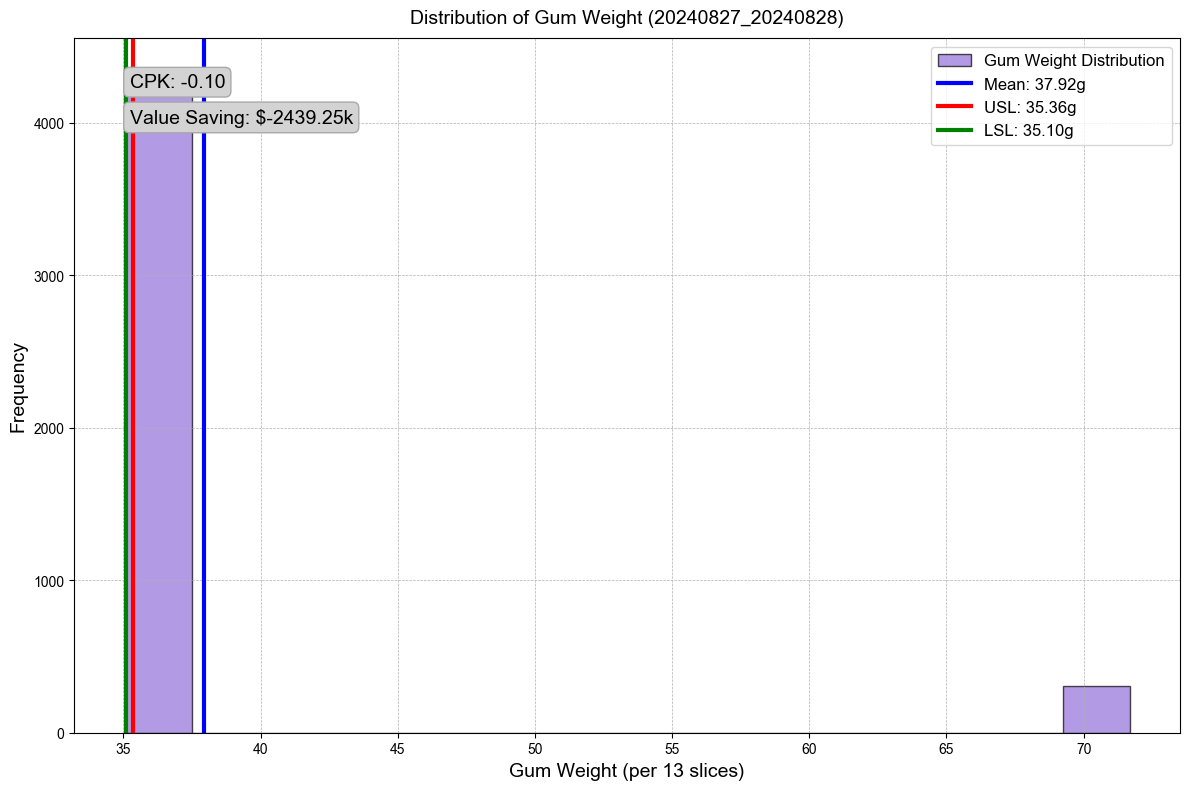

In [27]:
colors = {
    'hist_color': '#9370DB',  # purple
    'mean_color': '#0000FF',  # blue
    'usl_color': '#FF0000',  # red
    'lsl_color': '#008000',  # green
    'text_bg_color': '#D3D3D3',  # light grey
    'text_edge_color': '#A9A9A9'  # dark grey
}

# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.hist(df_mapped['actual_weight'], bins=15, edgecolor='black', alpha=0.7, color=colors['hist_color'], label='Gum Weight Distribution')

# Plot mean, USL, and LSL
plt.axvline(spc_mean, color=colors['mean_color'], linestyle='-', linewidth=3, label=f'Mean: {spc_mean:.2f}g')
plt.axvline(usl, color=colors['usl_color'], linestyle='-', linewidth=3, label=f'USL: {usl:.2f}g')
plt.axvline(lsl, color=colors['lsl_color'], linestyle='-', linewidth=3, label=f'LSL: {lsl:.2f}g')

# Add title with date range and smaller font size
plt.title(f'Distribution of Gum Weight ({start_dt}_{end_dt})', fontsize=14, fontweight='bold', y=1.01)

# Add labels
plt.xlabel('Gum Weight (per 13 slices)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add legend
plt.legend(frameon=True, fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate CPK and value saving
plt.text(0.05, 0.95, f'CPK: {spc_cpk:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))
plt.text(0.05, 0.90, f'Value Saving: ${value_saving:.2f}k', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))

plt.tight_layout()
plt.show()

#### Others

In [4]:
# 缺失值处理
df_nona = df_raw.dropna(subset=['1号冷辊出口压力', '1号冷辊入口压力'])
print(df_nona.isna().sum())
df_plc = df_nona.fillna('ffill')

timestamp                          0
1号冷辊入口压力                           0
1号冷辊入口温度                           1
1号冷辊出口压力                           0
1号冷辊出口温度                           3
1号冷辊皮带速度                          11
1号辊轮速度                            59
1号辊间隙                             42
2号冷辊入口压力                           3
2号冷辊入口温度                           5
2号冷辊出口压力                           5
2号冷辊出口温度                           7
2号冷辊皮带速度                          23
2号辊轮速度                            57
2号辊间隙                             38
3号辊轮速度                            54
3号辊间隙                             34
Circular Scoring Rollers 圆刀速度     18
Cooling Roller 辊轮速度               49
Cross Scoring Rollers 横刀速度         1
Forming Roller 定型辊间隙              29
Forming Roller 辊轮速度               45
入口胶温度                              6
出口胶温度L                             7
出口胶温度R                            10
大辊速度                              50
大辊间隙                              30
挤